In [1]:
from tms_risk.utils.data import Subject, get_tms_subjects, get_tms_conditions
import seaborn as sns
from tqdm.contrib.itertools import product
import pandas as pd
import pingouin

In [2]:
subjects = [Subject(sub) for sub in get_tms_subjects(exclude_outliers=True)]

/Users/gdehol/mambaforge/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
import pymc as pm

In [4]:
import notebook

In [5]:
pars = []
keys = []

for sub, session in product(subjects, [1,2,3]):

    # try:
    pars.append(sub.get_prf_parameters_volume(session, smoothed=True, retroicor=False, denoise=True, cross_validated=False, natural_space=True, roi='NPC12r'))
    keys.append((sub.subject, session))
    # except Exception as e:
    #     print(e)


  0%|          | 0/105 [00:00<?, ?it/s]

Using /data/ds-tmsrisk/derivatives/ips_masks/sub-01/func/ses-1/sub-01_space-T1w_desc-NPC12r_mask.nii.gz
Using /data/ds-tmsrisk/derivatives/ips_masks/sub-01/func/ses-2/sub-01_space-T1w_desc-NPC12r_mask.nii.gz
Using /data/ds-tmsrisk/derivatives/ips_masks/sub-01/func/ses-3/sub-01_space-T1w_desc-NPC12r_mask.nii.gz
Using /data/ds-tmsrisk/derivatives/ips_masks/sub-02/func/ses-1/sub-02_space-T1w_desc-NPC12r_mask.nii.gz
Using /data/ds-tmsrisk/derivatives/ips_masks/sub-02/func/ses-2/sub-02_space-T1w_desc-NPC12r_mask.nii.gz
Using /data/ds-tmsrisk/derivatives/ips_masks/sub-02/func/ses-3/sub-02_space-T1w_desc-NPC12r_mask.nii.gz
Using /data/ds-tmsrisk/derivatives/ips_masks/sub-03/func/ses-1/sub-03_space-T1w_desc-NPC12r_mask.nii.gz
Using /data/ds-tmsrisk/derivatives/ips_masks/sub-03/func/ses-2/sub-03_space-T1w_desc-NPC12r_mask.nii.gz
Using /data/ds-tmsrisk/derivatives/ips_masks/sub-03/func/ses-3/sub-03_space-T1w_desc-NPC12r_mask.nii.gz
Using /data/ds-tmsrisk/derivatives/ips_masks/sub-04/func/ses-1/s

In [6]:
pars = pd.concat(pars, keys=keys, names=['subject', 'session'])

In [7]:
tms_conditions = get_tms_conditions()
for key in tms_conditions:
    tms_conditions[key][1] = 'baseline'

pars['stimulation_condition'] = pars.reset_index().apply(lambda d: tms_conditions[d['subject']][d['session']],  axis=1).values
pars = pars.set_index('stimulation_condition', append=True)
pars.index = pars.index.set_names('voxel', level=-2)

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,stimulation_condition,1,34,1.635642,0.209585,0.015228,1.0


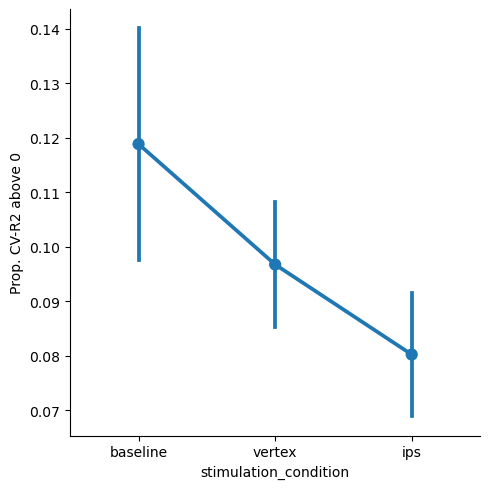

In [8]:
cvr2 = pars.groupby(['subject', 'session', 'stimulation_condition'])['cvr2'].apply(lambda x: (x>0.0).mean()).to_frame('Prop. CV-R2 above 0')

sns.catplot(cvr2.reset_index(), x='stimulation_condition', y='Prop. CV-R2 above 0', kind='point', errorbar='se', dodge=True)
pingouin.rm_anova(cvr2.drop('baseline', level='stimulation_condition').reset_index(), dv='Prop. CV-R2 above 0', within='stimulation_condition', subject='subject')

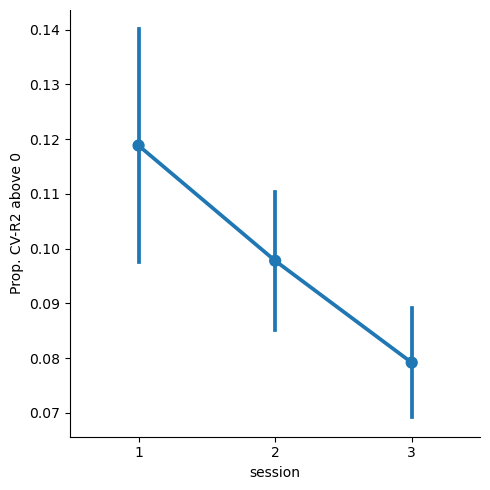

In [9]:
cvr2 = pars.groupby(['subject', 'session', 'stimulation_condition'])['cvr2'].apply(lambda x: (x>0.0).mean()).to_frame('Prop. CV-R2 above 0')

sns.catplot(cvr2.reset_index(), x='session', y='Prop. CV-R2 above 0', kind='point', errorbar='se', dodge=True)
# pingouin.rm_anova(cvr2.drop('baseline', level='stimulation_condition').reset_index(), dv='Prop. CV-R2 above 0', within='stimulation_condition', subject='subject')

In [10]:
cvr2.reset_index()

,subject,session,stimulation_condition,Prop. CV-R2 above 0
0,01,1,baseline,0.229617
1,01,2,vertex,0.118136
2,01,3,ips,0.101498
3,02,1,baseline,0.022495
4,02,2,vertex,0.067485
...,...,...,...,...
100,72,2,ips,0.230038
101,72,3,vertex,0.072243
102,74,1,baseline,0.188544
103,74,2,ips,0.047733


In [11]:
import bambi

cvr2 = pars.groupby(['subject', 'session', 'stimulation_condition'])['cvr2'].apply(lambda x: (x>0.0).mean()).to_frame('prop_cvr2')

model = bambi.Model('prop_cvr2 ~ C(session)*stimulation_condition + (1|subject)', data=cvr2.reset_index())

idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(session), stimulation_condition, C(session):stimulation_condition, 1|subject_sigma, 1|subject_offset, prop_cvr2_sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'C(session)'}>,
        <Axes: title={'center': 'C(session)'}>],
       [<Axes: title={'center': 'stimulation_condition'}>,
        <Axes: title={'center': 'stimulation_condition'}>],
       [<Axes: title={'center': 'C(session):stimulation_condition'}>,
        <Axes: title={'center': 'C(session):stimulation_condition'}>],
       [<Axes: title={'center': '1|subject_sigma'}>,
        <Axes: title={'center': '1|subject_sigma'}>],
       [<Axes: title={'center': 'prop_cvr2_sigma'}>,
        <Axes: title={'center': 'prop_cvr2_sigma'}>],
       [<Axes: title={'center': '1|subject'}>,
        <Axes: title={'center': '1|subject'}>]], dtype=object)

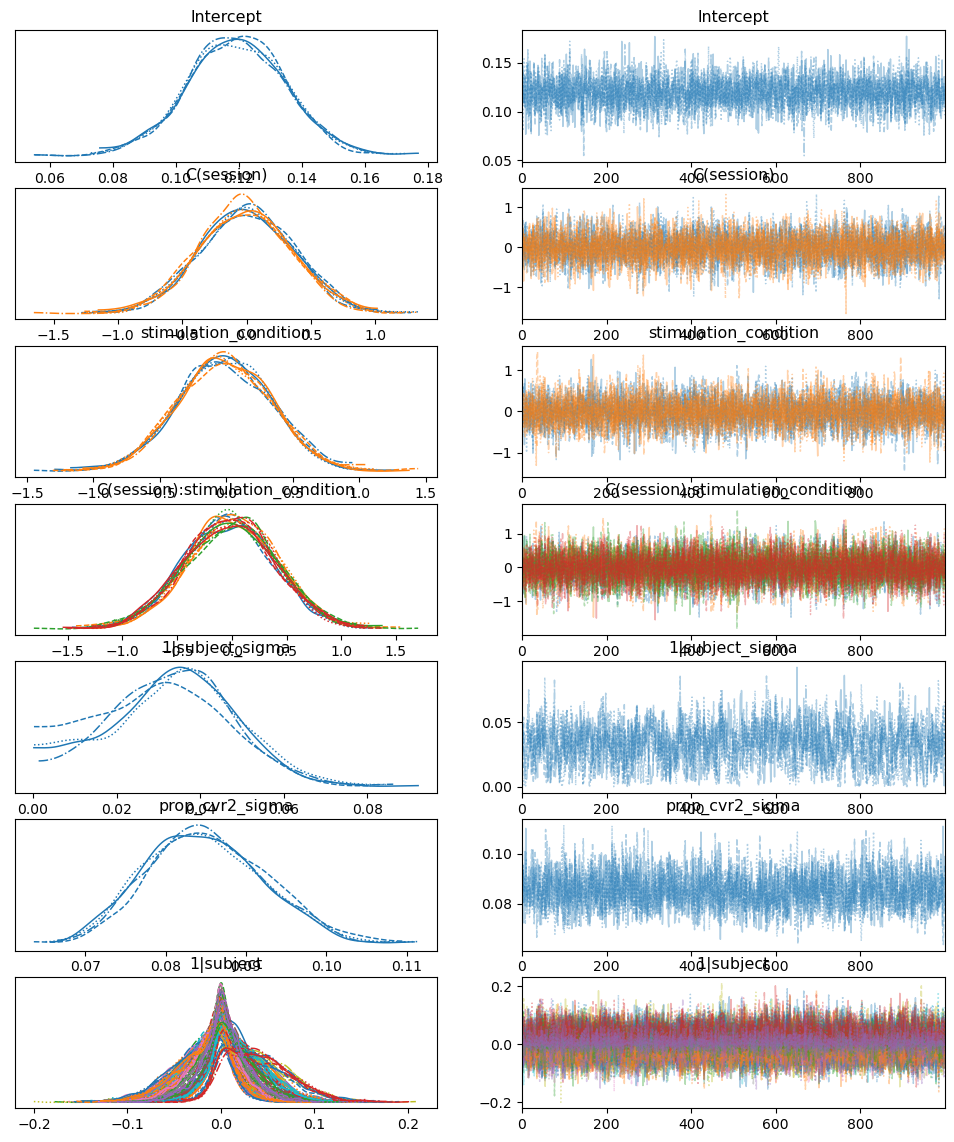

In [12]:
import arviz as az

az.plot_trace(idata)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


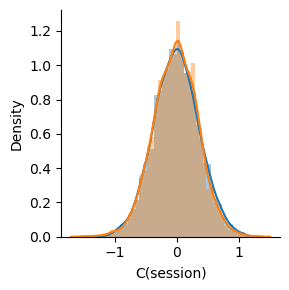

In [ ]:
d = idata.posterior['C(session)'].to_dataframe()

g = sns.FacetGrid(d.reset_index(), hue='C(session)_dim')
g.map(sns.distplot, 'C(session)')


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


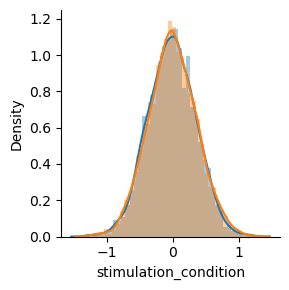

In [ ]:
d = idata.posterior['stimulation_condition'].to_dataframe()

g = sns.FacetGrid(d.reset_index(), hue='stimulation_condition_dim')
g.map(sns.distplot, 'stimulation_condition')


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_66306/1796472620.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pars['mu'])


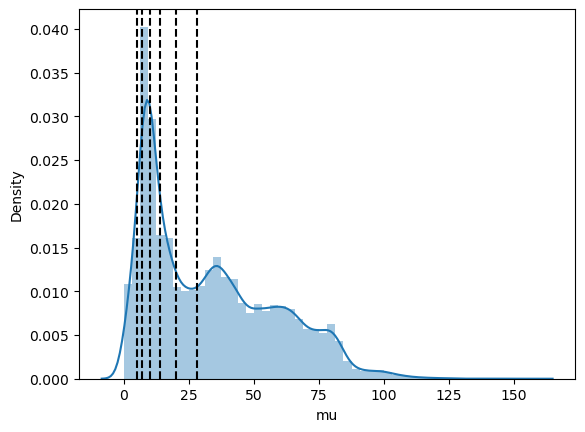

In [ ]:
import matplotlib.pyplot as plt
sns.distplot(pars['mu'])
for x in [5, 7, 10, 14, 20, 28]:
    plt.axvline(x, c='k', ls='--')

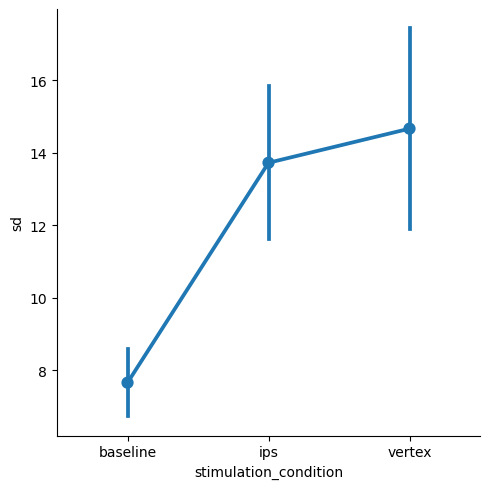

In [ ]:
tmp = pars[pars.cvr2 > 0.0].groupby(['subject', 'stimulation_condition']).mean().reset_index()


sns.catplot(tmp, x='stimulation_condition', y='sd', kind='point', errorbar='se')

In [ ]:
tmp = pars.droplevel('stimulation_condition').unstack(['session'])
tmp = tmp[tmp[('r2', 1)] > 0.125]

# r = pars.stack([0]).to_frame('value').droplevel('stimulation_condition').unstack(['session'])
r = tmp.stack('parameter').groupby(['subject','parameter']).corr()
r.groupby(['parameter', 'session']).mean()

session                   1         2         3
parameter session                              
amplitude 1        1.000000  0.164317  0.244970
          2        0.164317  1.000000  0.167668
          3        0.244970  0.167668  1.000000
baseline  1        1.000000  0.236244  0.370706
          2        0.236244  1.000000  0.332881
          3        0.370706  0.332881  1.000000
cvr2      1        1.000000  0.087205 -0.028056
          2        0.087205  1.000000 -0.032414
          3       -0.028056 -0.032414  1.000000
mu        1        1.000000  0.130590  0.139452
          2        0.130590  1.000000  0.223961
          3        0.139452  0.223961  1.000000
r2        1        1.000000  0.038057  0.058388
          2        0.038057  1.000000  0.217877
          3        0.058388  0.217877  1.000000
sd        1        1.000000 -0.005410  0.248448
          2       -0.005410  1.000000 -0.025526
          3        0.248448 -0.025526  1.000000

In [ ]:
import numpy as np

n_subjects, r1_ips, r1_vertex = [], [], []
pars_sessions = pars.droplevel('session').unstack(['stimulation_condition'])
r2s = np.linspace(0.00, 0.25)

for r2 in r2s:

    tmp = pars_sessions[pars_sessions[('r2', 'baseline')] > r2] 
    
    r1_ips.append(pingouin.corr(tmp[('mu', 'baseline')], tmp[('mu', 'ips')]).iloc[0].r)
    r1_vertex.append(pingouin.corr(tmp[('mu', 'baseline')], tmp[('mu', 'vertex')]).iloc[0].r)
    n_subjects.append(len(tmp.index.unique(level='subject')))

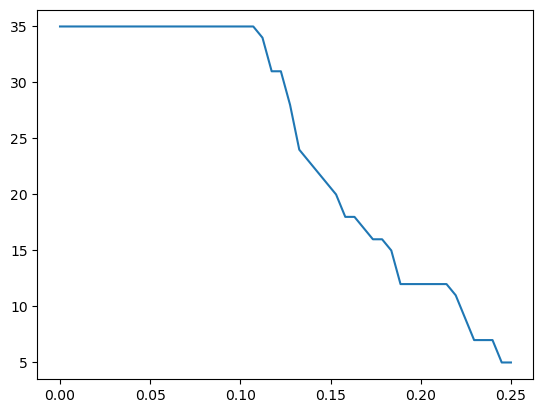

In [ ]:
plt.plot(r2s, n_subjects)

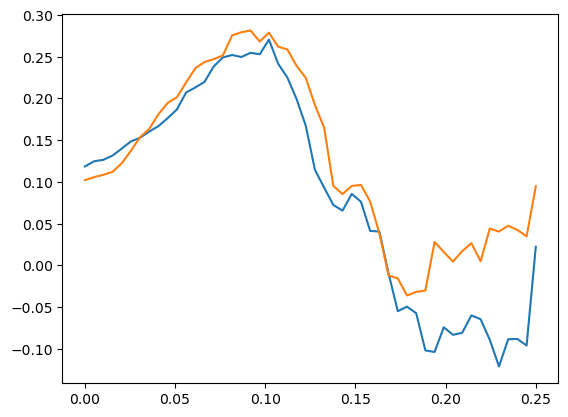

In [ ]:
plt.plot(r2s, r1_vertex)
plt.plot(r2s, r1_ips)

In [ ]:
import numpy as np

n_subjects, r1_ips, r1_vertex = [], [], []
pars_sessions = pars.droplevel('session').unstack(['stimulation_condition'])
r2s = np.linspace(0.00, 0.15)

for r2 in r2s:

    tmp = pars_sessions[pars_sessions[('cvr2', 'baseline')] > r2] 
    
    r1_ips.append(pingouin.corr(tmp[('mu', 'baseline')], tmp[('mu', 'ips')]).iloc[0].r)
    r1_vertex.append(pingouin.corr(tmp[('mu', 'baseline')], tmp[('mu', 'vertex')]).iloc[0].r)
    n_subjects.append(len(tmp.index.unique(level='subject')))

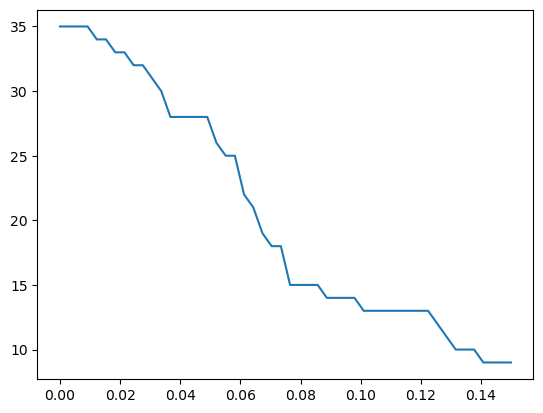

In [ ]:
plt.plot(r2s, n_subjects)

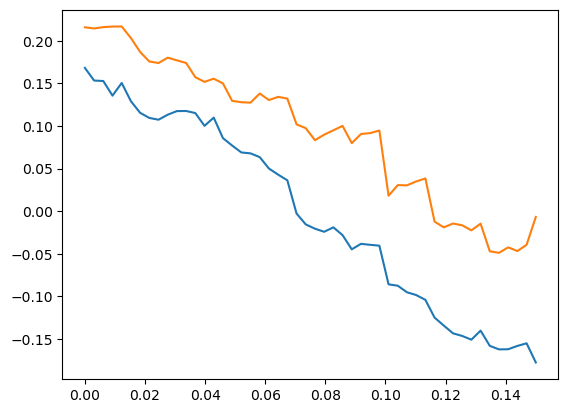

In [ ]:
plt.plot(r2s, r1_vertex)
plt.plot(r2s, r1_ips)

In [ ]:
import scipy.stats as ss

# Baseline-based CVr2 thresholding

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_66306/1276904902.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp['mask'] = tmp[('cvr2', 'baseline')] > 0.0
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the

,,Source,ddof1,ddof2,F,p-unc,ng2,eps
parameter,,,,,,,,
amplitude,0,stimulation_condition,1,34,0.078704,0.780762,0.000922,1.0
baseline,0,stimulation_condition,1,34,0.260999,0.612736,0.002235,1.0
cvr2,0,stimulation_condition,1,34,0.093409,0.761750,0.001204,1.0
mu,0,stimulation_condition,1,34,5.104025,0.030395,0.031010,1.0
r2,0,stimulation_condition,1,34,0.112263,0.739641,0.000806,1.0
sd,0,stimulation_condition,1,34,0.000459,0.983035,0.000006,1.0


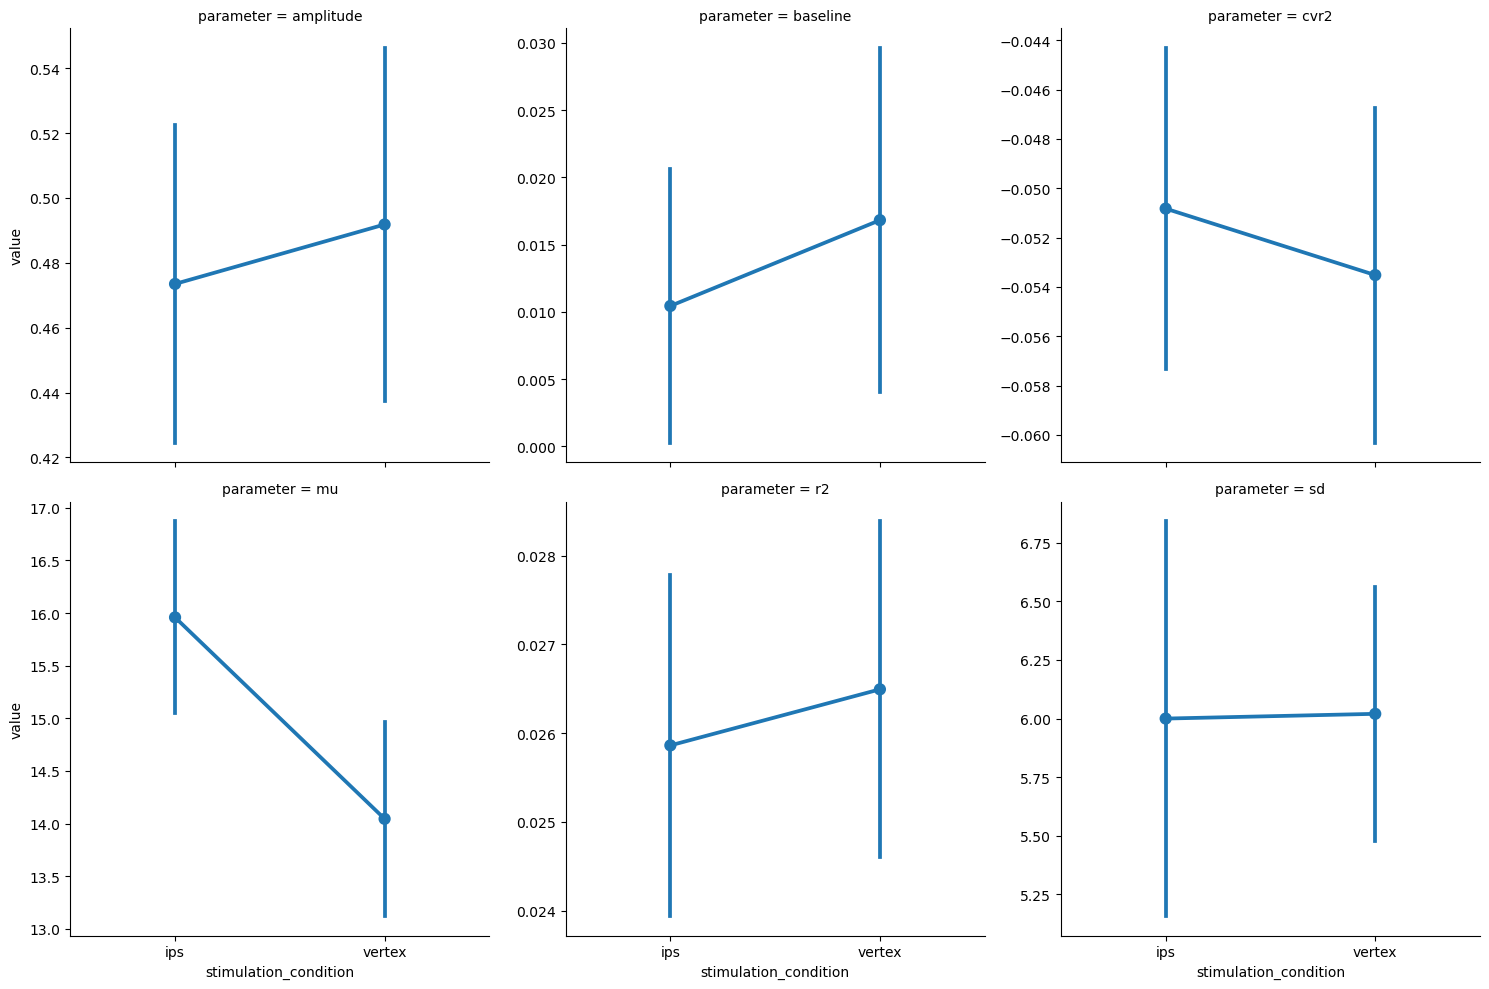

In [ ]:
tmp = pars.unstack(['stimulation_condition', 'session']).fillna(0.0)
tmp['mask'] = tmp[('cvr2', 'baseline')] > 0.0
# tmp['mask'] = tmp[('r2', 'baseline')] > 0.1

tmp['mask'].mean()
tmp = tmp.loc[tmp['mask'].values]

tmp = tmp.drop('mask', axis=1).stack([0, 1, 2]).to_frame('value')
tmp = tmp.drop('baseline', level='stimulation_condition').groupby(['subject', 'stimulation_condition', 'parameter']).mean().reset_index()

sns.catplot(tmp, x='stimulation_condition', y='value', col='parameter', col_wrap=3, sharey=False, kind='point', errorbar='se')

tmp.groupby('parameter').apply(lambda d: pingouin.rm_anova(d, dv='value', within='stimulation_condition', subject='subject'))

## Within-session CVR2 threshold

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(

,,Source,ddof1,ddof2,F,p-unc,ng2,eps
parameter,,,,,,,,
amplitude,0,stimulation_condition,1,34,6.484934,0.015577,0.081350,1.0
baseline,0,stimulation_condition,1,34,0.008839,0.925649,0.000117,1.0
cvr2,0,stimulation_condition,1,34,3.430808,0.072689,0.029218,1.0
mu,0,stimulation_condition,1,34,0.647852,0.426474,0.006972,1.0
r2,0,stimulation_condition,1,34,1.382272,0.247882,0.010093,1.0
sd,0,stimulation_condition,1,34,0.091597,0.764000,0.001073,1.0


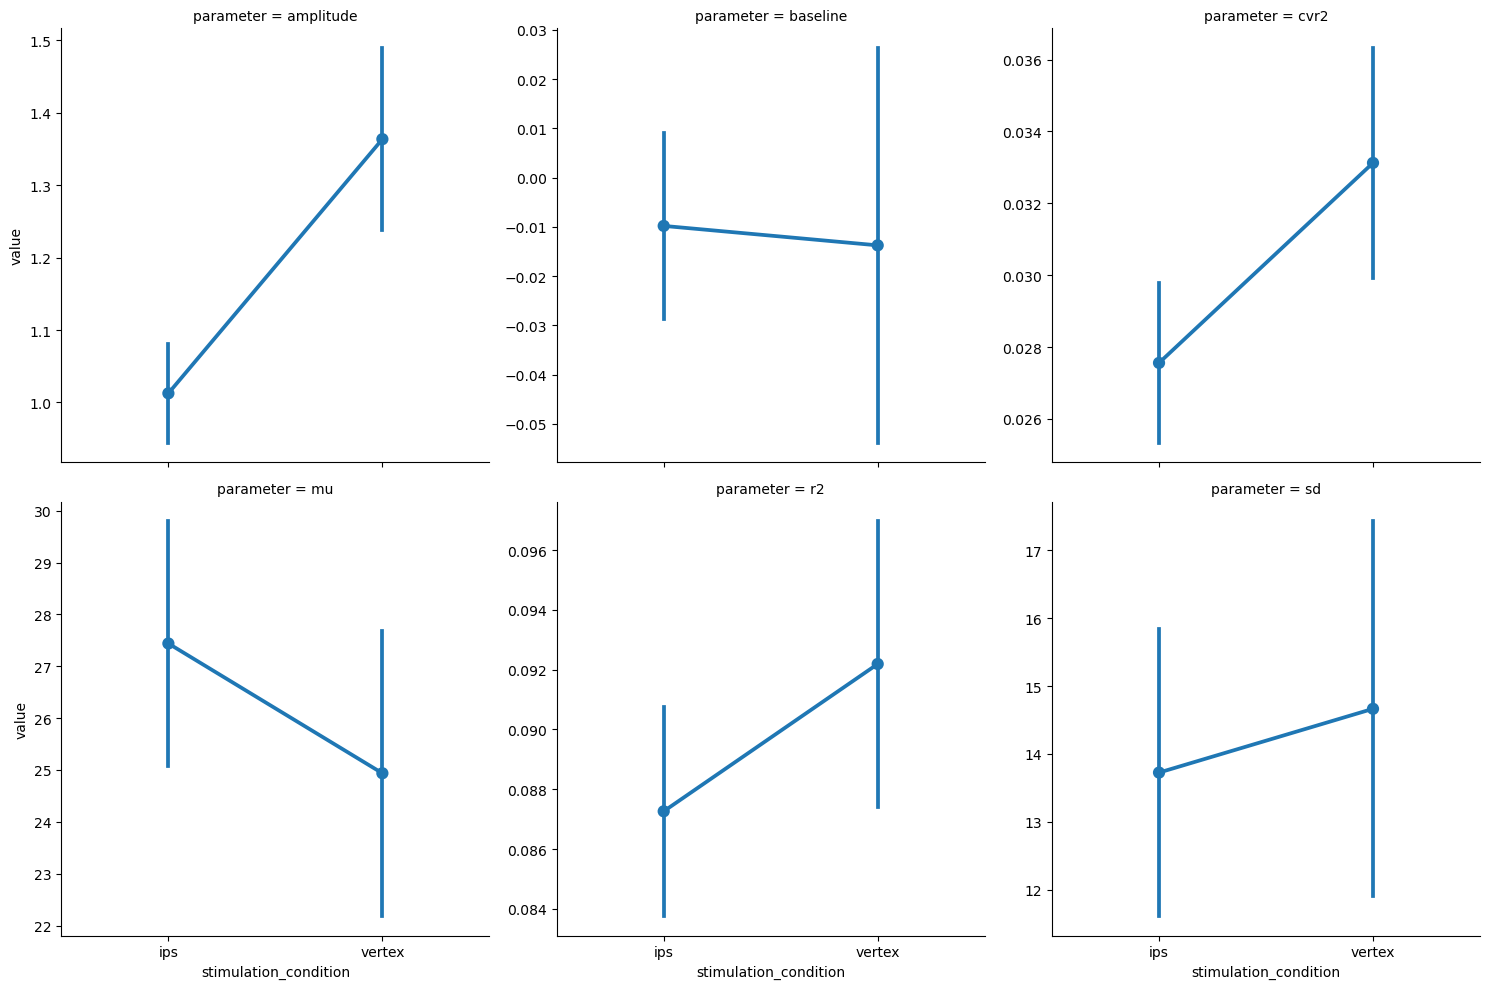

In [ ]:
tmp = pars[pars.cvr2>0.00]
# tmp = pars[pars.r2>0.10]

tmp = tmp.stack([0]).to_frame('value')
tmp = tmp.drop('baseline', level='stimulation_condition').groupby(['subject', 'stimulation_condition', 'parameter']).mean().reset_index()

sns.catplot(tmp, x='stimulation_condition', y='value', col='parameter', col_wrap=3, sharey=False, kind='point', errorbar='se')

import pingouin
tmp.groupby('parameter').apply(lambda d: pingouin.rm_anova(d, dv='value', within='stimulation_condition', subject='subject'))

# No thresholding

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(

,,Source,ddof1,ddof2,F,p-unc,ng2,eps
parameter,,,,,,,,
amplitude,0,stimulation_condition,1,34,1.134858,0.294248,0.011852,1.0
baseline,0,stimulation_condition,1,34,0.088464,0.767949,0.001124,1.0
cvr2,0,stimulation_condition,1,34,0.264579,0.610319,0.003011,1.0
mu,0,stimulation_condition,1,34,1.830727,0.184971,0.016611,1.0
r2,0,stimulation_condition,1,34,0.742030,0.395046,0.005775,1.0
sd,0,stimulation_condition,1,34,0.035723,0.851213,0.000320,1.0


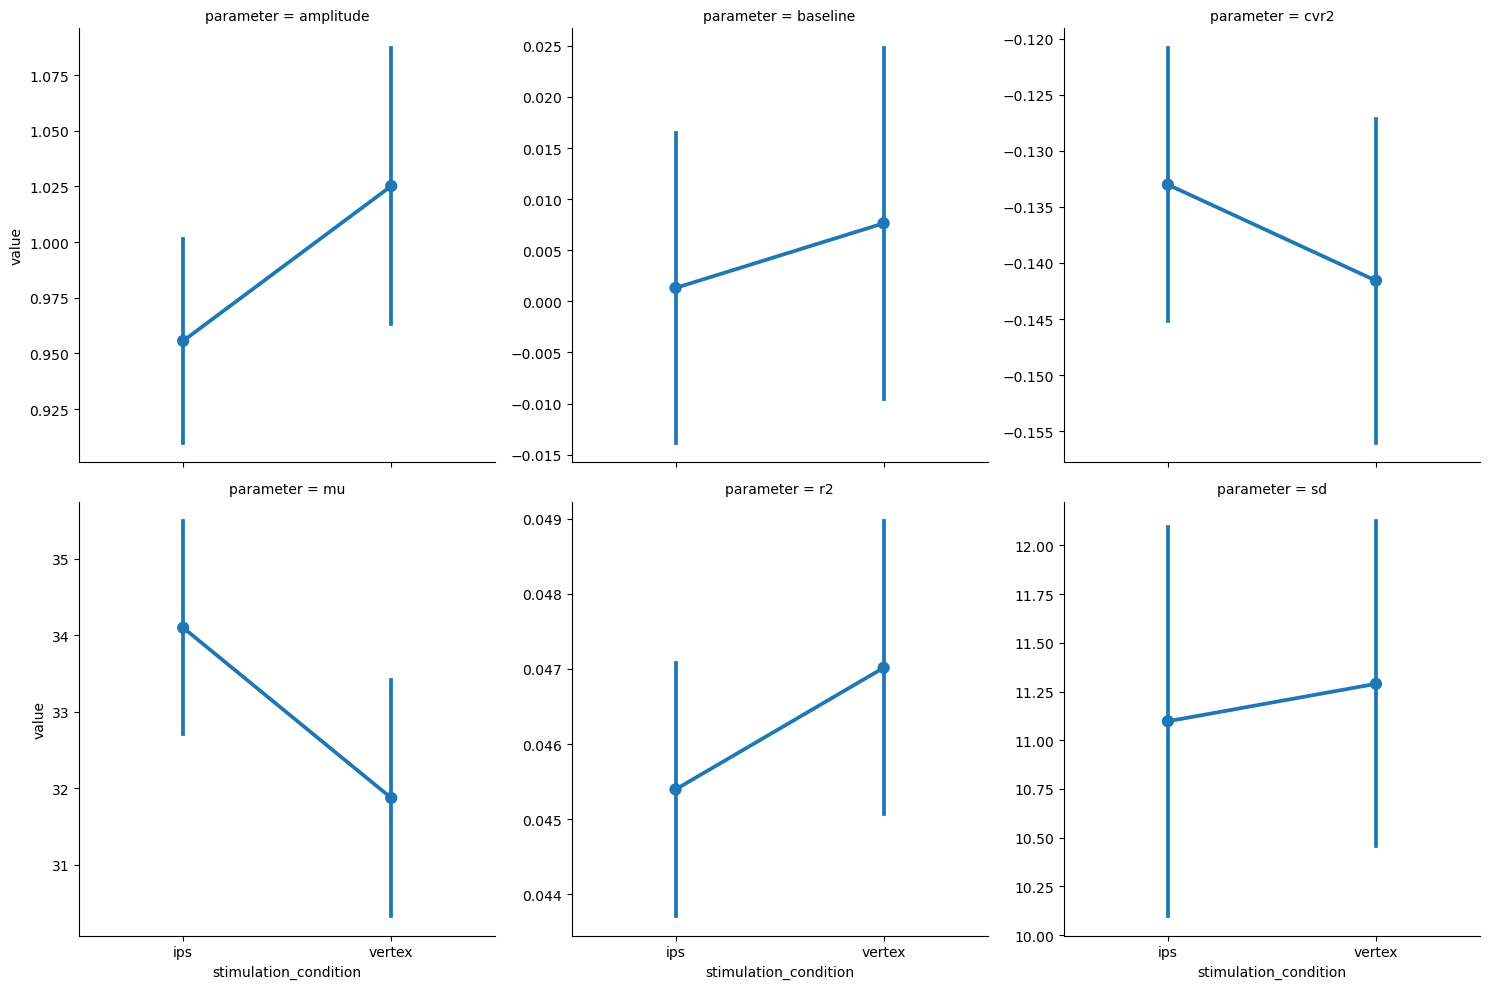

In [ ]:
tmp = pars.copy()

tmp = tmp.stack([0]).to_frame('value')
tmp = tmp.drop('baseline', level='stimulation_condition').groupby(['subject', 'stimulation_condition', 'parameter']).mean().reset_index()

sns.catplot(tmp, x='stimulation_condition', y='value', col='parameter', col_wrap=3, sharey=False, kind='point', errorbar='se')
tmp.groupby('parameter').apply(lambda d: pingouin.rm_anova(d, dv='value', within='stimulation_condition', subject='subject'))